In [303]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
from backend.data_models.save_to_db import get_ratings
import numpy as np
pd.options.display.max_rows = 100
from sklearn.preprocessing import LabelEncoder

# Modeling
from matrix_factorization import BaselineModel, KernelMF, train_update_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Other
import random
    
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [304]:
ratings = pd.read_csv('data/ratings.csv')

In [305]:
# # Get top users and top movies
# top_users = set(ratings["member_id"].value_counts().nlargest(2000).index) | {"ard_s", "miloujane", "abstraxia"}
# top_films = set(ratings["film_id"].value_counts().nlargest(1000).index)

# # Filter the original DataFrame
# movie_data = ratings[ratings["member_id"].isin(top_users) & ratings["film_id"].isin(top_films)].dropna()
movie_data = ratings.rename(columns={'member_id': 'user_name', "film_id": "item_id"}).dropna()

# # Initialize LabelEncoder
# label_encoder = LabelEncoder()

# # Apply the label encoder to the 'member_id' column
# ratings['member_id'] = label_encoder.fit_transform(ratings['member_id'])

In [315]:
film_id2slug = dict(zip(movie_data['item_id'], movie_data['slug']))

What is the purpose of this class?

The purpose of this class is to:
- train a matrix factorization model of varying kind (linear, sigmoid, rbf)
- test the model on a test set
- update the model for a new user and generate predictions

In order to do this, we need:
- methods to handle the rating data, transforming it into the appropriate format and splitting it
- methods to train the model with a provided set of hyperparameters
- methods to predict on a test set and compute a loss
- methods to update the model for a new user and generate predictions
- a dictionary to transform the members into numerical ids and back

What to figure out:
- best learning parameters
- how does reg affect the rankings other than preventing the model from overfitting?

In [402]:
class MF_Recommender():

    def __init__(self, movie_data):

        self.movie_data = movie_data
        self.user_name2id = {name: idx for idx, name in enumerate(sorted(movie_data['user_name']))}
        self.id2username = {idx: name for name, idx in self.user_name2id.items()}

        return None
    
    def _assign_user_id(self, data):
        
        data['user_id'] = data['user_name'].map(self.user_name2id)
        return data

    def prepare_data(self):

        self.movie_data = self._assign_user_id(movie_data)
        X = self.movie_data[['user_id', 'item_id']]
        y = self.movie_data['rating']

        # Split movie data into train and test set
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2)

        # Prepare data for online learning
        # self.X_train_initial, self.y_train_initial, self.X_train_update, self.y_train_update, self.X_test_update, self.y_test_update = train_update_test_split(movie_data, frac_new_users=0.2)

        return None

    def train(self, n_epochs=20, n_factors=100, verbose=1, lr=0.001, reg=0.005):
        # train model given parameters and prepared dataset
        # TODO update this such that it accepts different models
        self.matrix_fact = KernelMF(n_epochs = n_epochs, 
                                    n_factors = n_factors, 
                                    verbose = verbose, 
                                    lr = lr, 
                                    reg = reg,
                                    min_rating=1,
                                    max_rating=10)
        
        self.matrix_fact.fit(self.X_train, self.y_train)

        return None

    def test(self):
        # use a trained model to predict on a test set and compute a loss
        pred = self.matrix_fact.predict(self.X_test)
        rmse = mean_squared_error(self.y_test, pred)

        print(f'\nTest RMSE: {rmse:.4f}')

    def get_recommendations(self, user_name):
        # get recommendations for an existing user
        user_id = self.user_name2id[user_name]
        items_known = self.X_train.query('user_id == @user_id')['item_id']
        recommendations = self.matrix_fact.recommend(user=user_id, 
                                                     items_known=items_known)
        return recommendations
    
    def update_and_recommend(self, user_history):
        
        # take in user history for a new user, update model and generate preds
        temp_user_id = 999999999
        user_history['user_id'] = temp_user_id
        X_new = user_history[['user_id', 'item_id']]
        y_new = user_history['rating']
        
        print('Warning: not excluding known items from recommendation')
        self.matrix_fact.update_users(X_new, y_new, lr=0.001, n_epochs=20, verbose=1)
        recs = self.matrix_fact.recommend(user=temp_user_id, 
                                          items_known=None, #X_new['item_id'], 
                                          amount=-1, 
                                          bound_ratings=True)
        
        recs = [{'user_id':x[0], 'item_id':x[1], 'prediction':x[2]} for x in recs.values]

        return recs


In [403]:
ard_data = movie_data[movie_data.user_name=='ard_s']
no_ard_data = movie_data[movie_data.user_name!='ard_s']

In [404]:
model = MF_Recommender(movie_data=no_ard_data)
model.prepare_data()
model.train(lr=0.01, n_epochs=10, reg=0.01)


Epoch  1 / 10  -  train_rmse: 1.5094204096136767
Epoch  2 / 10  -  train_rmse: 1.3750114815772612
Epoch  3 / 10  -  train_rmse: 1.263792875291683
Epoch  4 / 10  -  train_rmse: 1.1673518880946205
Epoch  5 / 10  -  train_rmse: 1.0949372176110554
Epoch  6 / 10  -  train_rmse: 1.0439117243243374
Epoch  7 / 10  -  train_rmse: 1.007348660159223
Epoch  8 / 10  -  train_rmse: 0.9804853890496951
Epoch  9 / 10  -  train_rmse: 0.9597337071066676
Epoch  10 / 10  -  train_rmse: 0.9441813615272334


In [413]:
user_history = ard_data
recs = model.update_and_recommend(user_history=user_history)
recs = pd.DataFrame(recs)
recs['title'] = recs['item_id'].apply(lambda x: film_id2slug[x])

/var/folders/9v/gkn4ykzn7pj9xmqvf66kw3hh0000gn/T/ipykernel_28008/3033983250.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_history['user_id'] = temp_user_id


Epoch  1 / 20  -  train_rmse: 1.1139301001019557
Epoch  2 / 20  -  train_rmse: 1.0866586187139198
Epoch  3 / 20  -  train_rmse: 1.0643862491833571
Epoch  4 / 20  -  train_rmse: 1.045725814014629
Epoch  5 / 20  -  train_rmse: 1.029585673344939
Epoch  6 / 20  -  train_rmse: 1.0155611464243557
Epoch  7 / 20  -  train_rmse: 1.002859866600001
Epoch  8 / 20  -  train_rmse: 0.9914975255646877
Epoch  9 / 20  -  train_rmse: 0.980871281974614
Epoch  10 / 20  -  train_rmse: 0.9709405088855942
Epoch  11 / 20  -  train_rmse: 0.9616036923662089
Epoch  12 / 20  -  train_rmse: 0.95267081130984
Epoch  13 / 20  -  train_rmse: 0.9442233955132475
Epoch  14 / 20  -  train_rmse: 0.9360782008020061
Epoch  15 / 20  -  train_rmse: 0.9282700587532448
Epoch  16 / 20  -  train_rmse: 0.9207318047126927
Epoch  17 / 20  -  train_rmse: 0.9135216038252351
Epoch  18 / 20  -  train_rmse: 0.9065227585013903
Epoch  19 / 20  -  train_rmse: 0.8997625244869333
Epoch  20 / 20  -  train_rmse: 0.8932044962723265


In [418]:
recs.head(20)

,user_id,item_id,prediction,title
0,999999999.0,607221.0,9.069517,cowboy-bebop
1,999999999.0,332099.0,9.020760,mario-puzos-the-godfather-the-complete-novel-for-television
2,999999999.0,72133.0,8.955063,the-human-condition
3,999999999.0,259011.0,8.952568,band-of-brothers
4,999999999.0,51818.0,8.895159,the-godfather
5,999999999.0,51349.0,8.886061,night-and-fog
6,999999999.0,51700.0,8.874892,12-angry-men
7,999999999.0,51931.0,8.828567,the-lord-of-the-rings-2003
8,999999999.0,43015.0,8.819301,harakiri
9,999999999.0,51816.0,8.804995,the-godfather-part-ii


<Axes: xlabel='alt_title'>

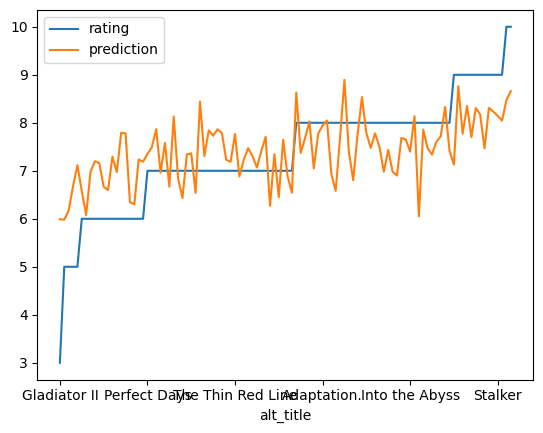

In [415]:
# Perform left join
user_history.merge(recs, how="left", left_on="item_id", right_on="item_id")[['alt_title', 'rating', 'prediction']].sort_values(by='rating').plot(x='alt_title', y=['rating', 'prediction'])

In [416]:
all = user_history.merge(recs, how="left", left_on="item_id", right_on="item_id")
all

,user_name,item_id,slug,rating,alt_title,user_id_x,user_id_y,prediction,title
0,ard_s,486978,gladiator-ii,3.0,Gladiator II,999999999,999999999.0,5.990773,gladiator-ii
1,ard_s,955184,queer-2024,5.0,Queer,999999999,999999999.0,5.981987,queer-2024
2,ard_s,989125,babygirl-2024,5.0,Babygirl,999999999,999999999.0,6.171960,babygirl-2024
3,ard_s,717471,better-man-2024,5.0,Better Man,999999999,999999999.0,6.677752,better-man-2024
4,ard_s,823648,beetlejuice-beetlejuice,6.0,Beetlejuice Beetlejuice,999999999,999999999.0,6.346373,beetlejuice-beetlejuice
...,...,...,...,...,...,...,...,...,...
99,ard_s,217536,inquiring-nuns,8.0,Inquiring Nuns,999999999,999999999.0,6.804511,inquiring-nuns
100,ard_s,51475,belle-de-jour,8.0,Belle de Jour,999999999,999999999.0,7.760173,belle-de-jour
101,ard_s,51666,the-good-the-bad-and-the-ugly,8.0,"The Good, the Bad and the Ugly",999999999,999999999.0,8.536416,the-good-the-bad-and-the-ugly
102,ard_s,70001,letter-never-sent,7.0,Letter Never Sent,999999999,999999999.0,7.866302,letter-never-sent


In [334]:
recs = recs.rename(columns={'film': 'item_id'})
recs.item_id = recs.item_id.astype(int)
recs

,member,item_id,prediction,title
0,999999999.0,1080342,9.756493,paint-drying
1,999999999.0,1163847,9.611334,madonna-the-celebration-tour-in-rio
2,999999999.0,642390,9.389921,i-may-destroy-you
3,999999999.0,650622,9.333168,nowhere-special
4,999999999.0,39687,9.299341,we-will-rock-you
...,...,...,...,...
259515,999999999.0,889754,2.640910,through-my-window-across-the-sea
259516,999999999.0,745421,2.631378,365-days-this-day
259517,999999999.0,51505,2.625480,the-birth-of-a-nation
259518,999999999.0,727449,2.597116,2025-the-world-enslaved-by-a-virus


In [332]:
recs[recs.title=='babygirl-2024']

,member,item_id,prediction,title


In [320]:
# recs = recs.rename(columns={'title': 'alt_title'})
# milou_data.merge(recs, on='alt_title')
milou_data.merge(recs, on='item_id', how='left')

,user_name,item_id,slug,rating,alt_title,user_id,member,prediction,title
0,miloujane,794384,a-want-in-her,9.0,A Want in Her,999999999,NaN,NaN,NaN
1,miloujane,1249226,huilende-bruiden,6.0,Huilende bruiden,999999999,NaN,NaN,NaN
2,miloujane,1249221,anima-2024-1,8.0,Anima,999999999,NaN,NaN,NaN
3,miloujane,997489,a-beautiful-imperfection,3.0,A Beautiful Imperfection,999999999,NaN,NaN,NaN
4,miloujane,989125,babygirl-2024,6.0,Babygirl,999999999,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
196,miloujane,226715,blind-child-2,10.0,Blind Child 2,999999999,NaN,NaN,NaN
197,miloujane,51280,singin-in-the-rain,6.0,Singin' in the Rain,999999999,NaN,NaN,NaN
198,miloujane,254061,the-bird-man,5.0,The Bird Man,999999999,NaN,NaN,NaN
199,miloujane,31098,the-scarlet-empress,6.0,The Scarlet Empress,999999999,NaN,NaN,NaN


This section can be moved towards data transformation